Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
216/216 [==============================] - 24s 59ms/step - loss: 1.4970 - accuracy: 0.5179 - val_loss: 1.2761 - val_accuracy: 0.5418
Epoch 2/100
216/216 [==============================] - 11s 51ms/step - loss: 1.1280 - accuracy: 0.5119 - val_loss: 1.0022 - val_accuracy: 0.5277
Epoch 3/100
216/216 [==============================] - 11s 53ms/step - loss: 0.9207 - accuracy: 0.5151 - val_loss: 0.8513 - val_accuracy: 0.5243
Epoch 4/100
216/216 [==============================] - 11s 53ms/step - loss: 0.8077 - accuracy: 0.5104 - val_loss: 0.7701 - val_accuracy: 0.5482
Epoch 5/100
216/216 [==============================] - 11s 52ms/step - loss: 0.7484 - accuracy: 0.5147 - val_loss: 0.7300 - val_accuracy: 0.5009
Epoch 6/100
216/216 [==============================] - 12s 56ms/step - loss: 0.7189 - accuracy: 0.5118 - val_loss: 0.7089 - val_accuracy: 0.5402
E

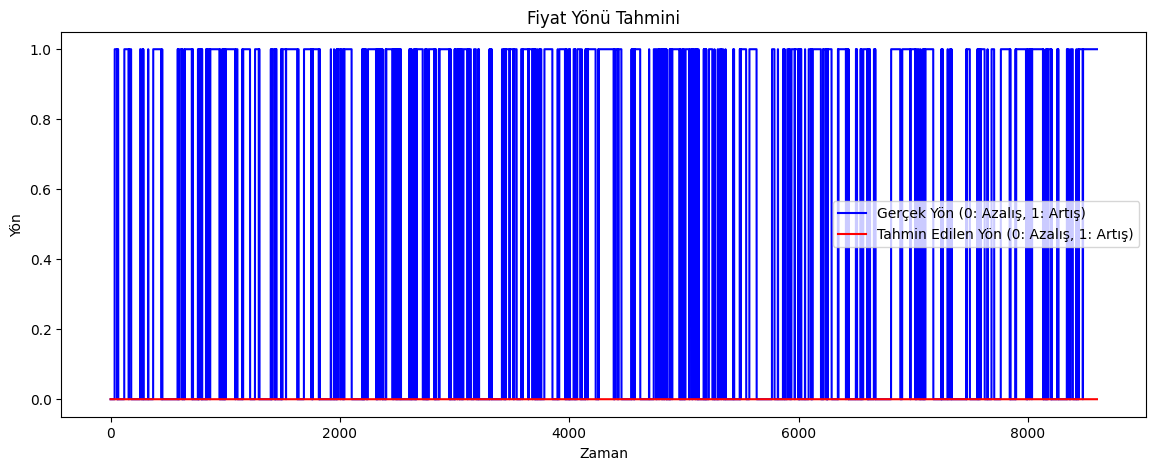

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import tensorflow as tf

tf.random.set_seed(1234)

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/dataset/BTCUSDT-1m-2020-09.csv'

column_names = [
    'open_time', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_volume', 'count', 'taker_buy_volume',
    'taker_buy_quote_volume', 'ignore'
]


data = pd.read_csv(file_path, header=None, names=column_names)

# Additional Features: Create moving averages and returns
data['ma_7'] = data['close'].rolling(window=7).mean()
data['ma_30'] = data['close'].rolling(window=30).mean()
data['return'] = data['close'].pct_change()

# Fill NA values with zero (or other strategy)
data.fillna(0, inplace=True)

# Select features including new ones
features = data[['close', 'volume']].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Function to create a dataset suitable for LSTM
def create_dataset(data, time_step, predict_ahead):
    X, y = [], []
    for i in range(len(data) - time_step - predict_ahead):
        X.append(data[i:(i + time_step)])
        if data[i + time_step + predict_ahead, 0] > data[i + time_step, 0]:
            y.append(1)  # Price will increase
        else:
            y.append(0)  # Price will decrease
    return np.array(X), np.array(y)

# Set time step and prediction horizon
time_step = 120
predict_ahead = 60  # 60 adım (1 saat) ileri tahmin
X, y = create_dataset(scaled_data, time_step, predict_ahead)

# Split the data into training and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape the data to be suitable for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Class weights to handle imbalanced dataset
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Create the model
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(time_step, X_train.shape[2]), kernel_regularizer=l2(0.001))))
model.add(Dropout(0.4))
model.add(Bidirectional(GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.4))
model.add(Bidirectional(GRU(units=64, return_sequences=False, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.4))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stop])

# Make predictions
predictions = model.predict(X_test)

# Adjust the threshold
threshold = 0.6  # Adjust based on validation performance
binary_predictions = (predictions > threshold).astype(int)

# Calculate the accuracy
accuracy = np.mean(binary_predictions == y_test.reshape(-1, 1))

print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual Direction (0: Decrease, 1: Increase)')
plt.plot(binary_predictions, color='red', label='Predicted Direction (0: Decrease, 1: Increase)')
plt.title('Price Direction Prediction')
plt.xlabel('Time')
plt.ylabel('Direction')
plt.legend()
plt.show()


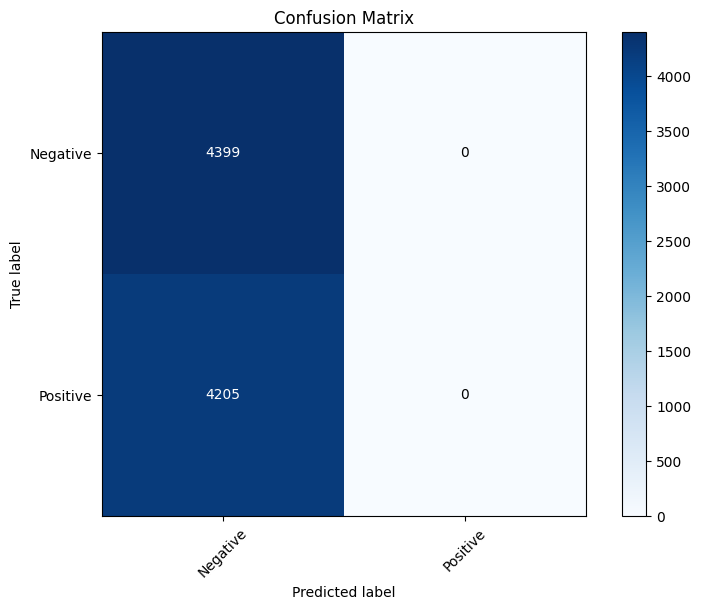

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68      4399
           1       0.00      0.00      0.00      4205

    accuracy                           0.51      8604
   macro avg       0.26      0.50      0.34      8604
weighted avg       0.26      0.51      0.35      8604



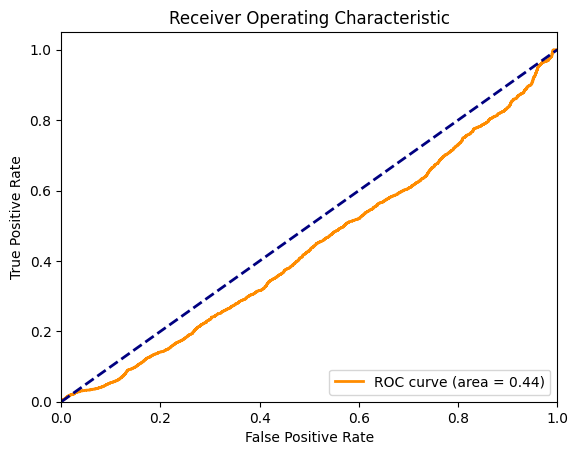

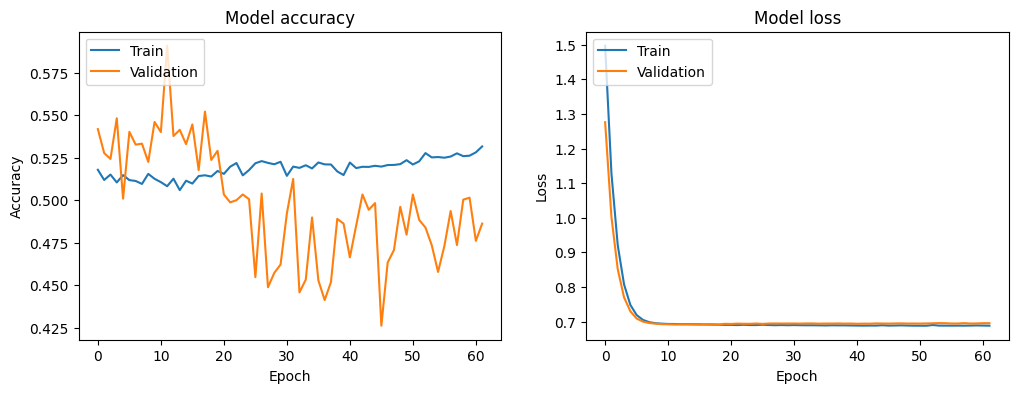

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Confusion Matrix
def plot_confusion_matrix(y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
    plt.yticks(tick_marks, ['Negative', 'Positive'])

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Classification Report
def print_classification_report(y_test, predictions):
    report = classification_report(y_test, predictions)
    print('Classification Report:\n', report)

# ROC Curve and AUC
def plot_roc_curve(y_test, y_probs):
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Accuracy and Loss Curves
def plot_accuracy_loss(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Example usage:
# history = model.fit(...)  # training the model
# y_probs = model.predict(X_test).ravel()  # Flatten the output to 1D array if needed
# predictions = (y_probs > 0.5).astype(int)
# y_test = y_test

plot_confusion_matrix(y_test, binary_predictions)
print_classification_report(y_test, binary_predictions)
plot_roc_curve(y_test, predictions)
plot_accuracy_loss(history)